In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px
from sklearn import preprocessing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df.shape

(40277, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

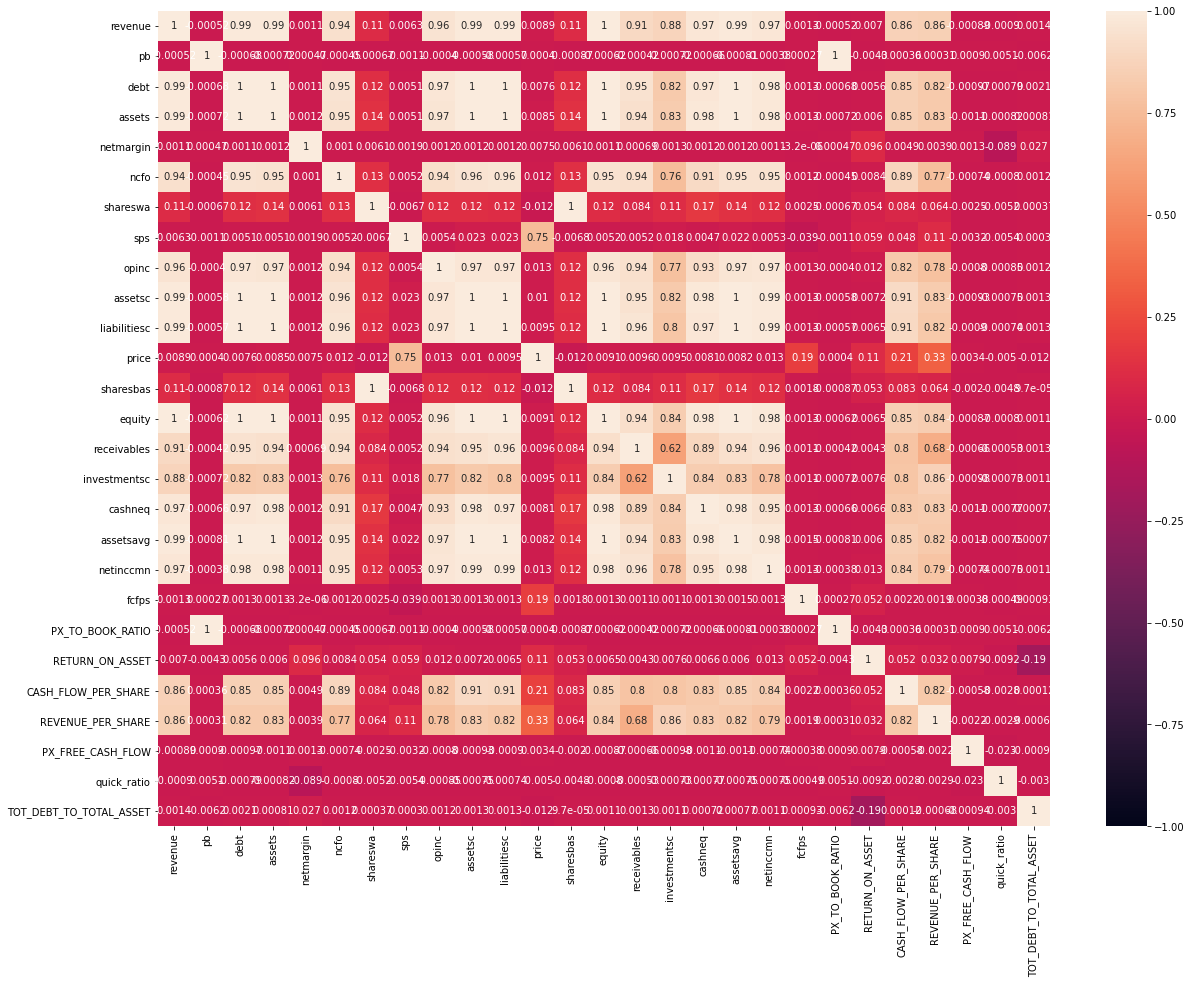

In [5]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [6]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [7]:
df['calendardate'].nunique() #let's see how many rows in calendardate

22

In [8]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [9]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [10]:
df['calendardate'] = pd.to_datetime(df['calendardate'])

In [11]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321467,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504182,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299008571,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710498,0.099426,0.427586,7.010309,1.933891,0.195735


In [12]:
#converting operating margin to a numerical data, apparently there're NAs, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

In [13]:
from scipy.stats.mstats import winsorize
import scipy.stats

In [14]:
#applying winsorization here. It is to transform the statistics by limiting extreme values in the statistical data
#to reduce the effect of possibly spurious outliers.

q_low = df['netmargin'].quantile(0.05)
q_hi = df['netmargin'].quantile(0.98)

df = df[(df['netmargin'] < q_hi) & (df['netmargin']>q_low)]

(array([ 21.,  34.,  58.,  96., 618., 562., 226., 136.,  38.,  32.]),
 array([-0.54 , -0.419, -0.298, -0.177, -0.056,  0.065,  0.186,  0.307,
         0.428,  0.549,  0.67 ]),
 <BarContainer object of 10 artists>)

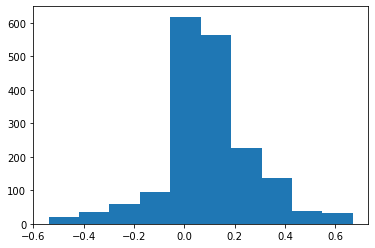

In [15]:
plt.hist(round(df['netmargin'], 2), bins = 10)

In [16]:
#applying Z score, to understand if a data value is greater or smaller than mean and how far away it is from the mean
#to see how many std away a data point is from the mean.

from scipy import stats

stats.zscore(round(df['netmargin'], 2))

array([-2.45362763,  0.76149094, -2.17159968, ..., -0.31021525,
       -1.21270467,  0.25384064])

In [17]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ', 'GLIBA', 'MRVL', 'NLOK'])] 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,...,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,...,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [18]:
df.isna().sum()

ticker                       0
revenue                      0
pb                           4
debt                         0
assets                       0
netmargin                    0
ncfo                         9
shareswa                     0
sps                          0
opinc                        0
assetsc                    418
liabilitiesc               419
price                        4
calendardate                 0
datekey                      0
sharesbas                    0
equity                       0
receivables                  0
investmentsc               418
cashneq                      0
assetsavg                    4
netinccmn                    3
fcfps                        6
PX_TO_BOOK_RATIO             4
RETURN_ON_ASSET              4
OPER_MARGIN                  0
CASH_FLOW_PER_SHARE          9
REVENUE_PER_SHARE            0
PX_FREE_CASH_FLOW           10
quick_ratio                419
TOT_DEBT_TO_TOTAL_ASSET      0
dtype: int64

In [19]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [20]:
df = df.dropna() #dropping null values

In [21]:
df.isna().sum() #check if dropped

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [22]:
df.info()

#check for infinity how many rows were dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386 entries, 16 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1386 non-null   object        
 1   revenue                  1386 non-null   float64       
 2   pb                       1386 non-null   float64       
 3   debt                     1386 non-null   float64       
 4   assets                   1386 non-null   float64       
 5   netmargin                1386 non-null   float64       
 6   ncfo                     1386 non-null   float64       
 7   shareswa                 1386 non-null   float64       
 8   sps                      1386 non-null   float64       
 9   opinc                    1386 non-null   float64       
 10  assetsc                  1386 non-null   float64       
 11  liabilitiesc             1386 non-null   float64       
 12  price                    1386 no

In [23]:
df = df[~df['ticker'].isin(['AUPH', 'NK', 'ZYME', 'ZGNX', 'LBRDA', 'CRON', 'TM', 'LNG', 'KMB', 'SBL', 'NSP', 'CL', 'CHWY',
                           'SHOP', 'DDOG', 'HL', 'SBH', 'CDLX', 'MMSI', 'LGND'])] 

#filtering rows, dont need these outliers ~ 

In [24]:
#copying the df to df_original, to use it when needed, to see the ticker

df_original = df.copy()

In [25]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks.

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
16,0.195382,-65.555556,0.621846,0.035415,-0.243414,10.140,1.454003,1.646590e+08,-0.337
30,0.572629,47.403295,3.514597,1.221921,0.134270,23.279,1.672204,2.708000e+09,0.229
51,0.050918,366.601307,0.791419,0.042444,-0.103884,22.487,1.579705,3.191640e+08,-0.288
65,0.195735,7.010309,0.427586,0.099426,0.012826,2.931,1.933891,1.975430e+09,-0.009
86,0.050232,156.673511,0.681077,0.132249,0.019134,25.289,2.922532,8.339430e+08,0.076


In [26]:
df.corr()

#check the correlation between features, looks good!

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,0.038313,-0.003321,0.013575,0.052710,-0.091573,-0.156482,-0.004516,0.026415
PX_FREE_CASH_FLOW,0.038313,1.000000,-0.006710,-0.005411,0.100148,0.006166,-0.005893,-0.002754,0.083525
REVENUE_PER_SHARE,-0.003321,-0.006710,1.000000,0.838350,0.019927,-0.009459,-0.038026,0.768236,-0.000779
CASH_FLOW_PER_SHARE,0.013575,-0.005411,0.838350,1.000000,0.113191,-0.005489,-0.058130,0.630334,0.094609
RETURN_ON_ASSET,0.052710,0.100148,0.019927,0.113191,1.000000,-0.036633,-0.024434,0.002309,0.647128
PX_TO_BOOK_RATIO,-0.091573,0.006166,-0.009459,-0.005489,-0.036633,1.000000,0.019030,-0.004722,-0.029635
quick_ratio,-0.156482,-0.005893,-0.038026,-0.058130,-0.024434,0.019030,1.000000,-0.010521,0.069237
equity,-0.004516,-0.002754,0.768236,0.630334,0.002309,-0.004722,-0.010521,1.000000,0.004443
netmargin,0.026415,0.083525,-0.000779,0.094609,0.647128,-0.029635,0.069237,0.004443,1.000000


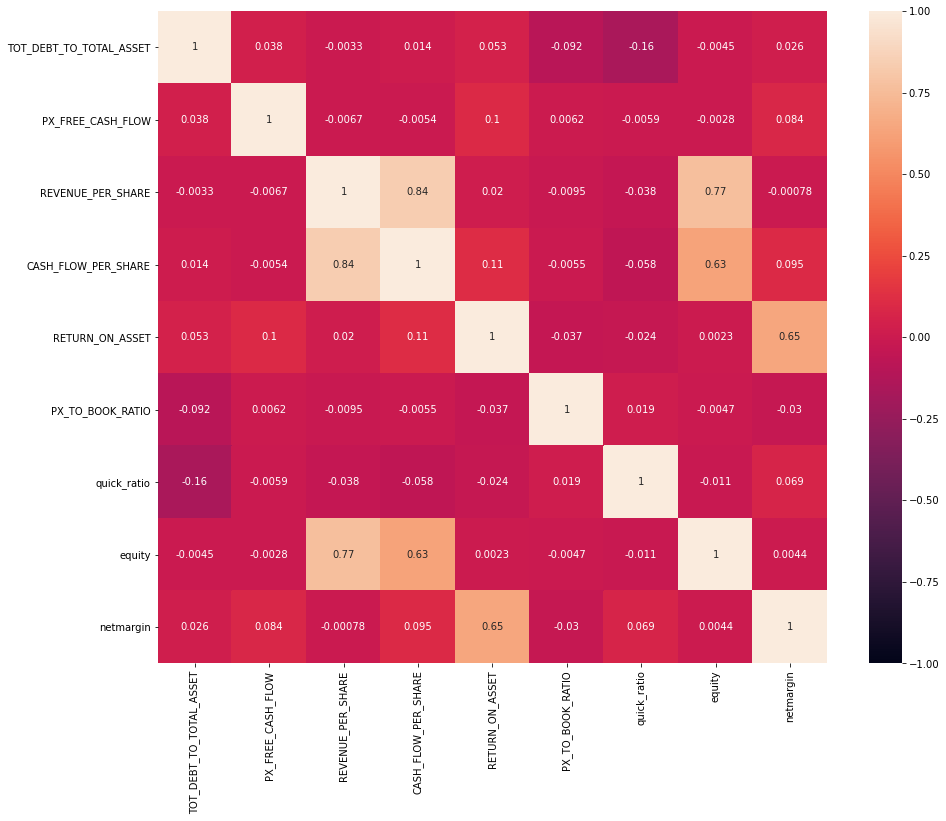

In [27]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [28]:
#still see some leftover correlations, let's drop them too

drop_cols = ['equity', 'REVENUE_PER_SHARE', 'RETURN_ON_ASSET']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
16,0.195382,-65.555556,0.035415,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,25.289,2.922532,0.076


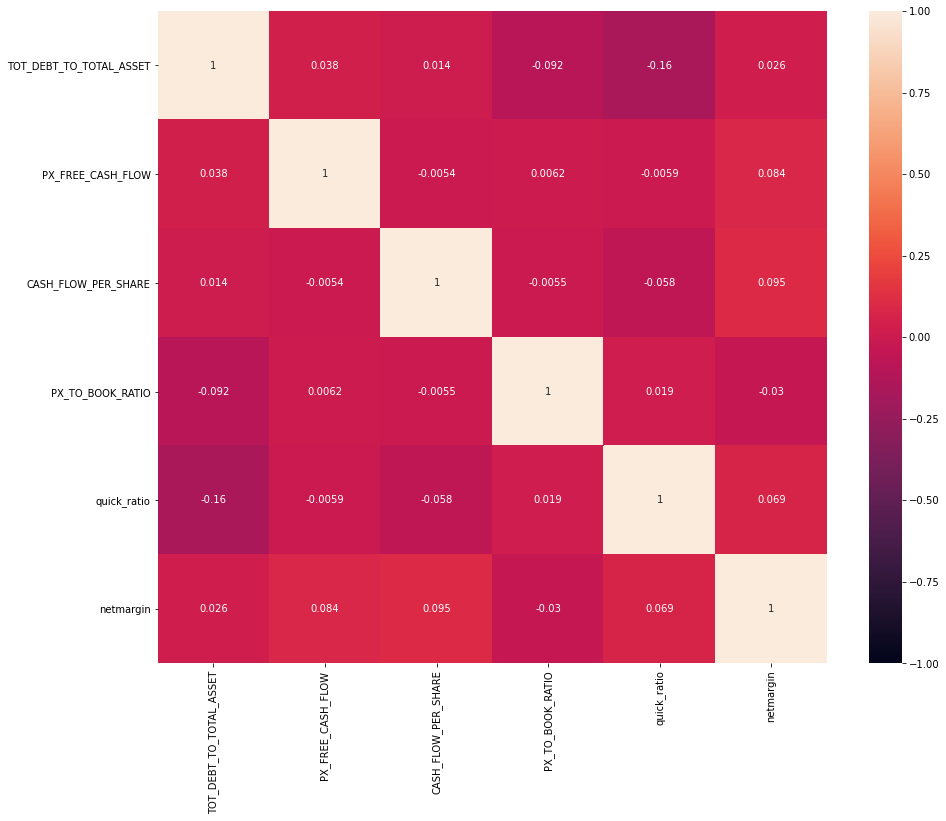

In [29]:
#now the data seems clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Features definitions

TOT_DEBT_TO_TOTAL_ASSET = The debt to total assets ratio is an indicator of a company's financial leverage. It tells you the percentage of a company's total assets that were financed by creditors. ... Debt is the total amount of all liabilities (current liabilities and long-term liabilities).

PX_TO_BOOK_RATIO =  is calculated by dividing a company's stock price by its book value per share. Low P/B ratios can be indicative of undervalued stocks, and can be useful when conducting a thorough analysis of a stock.

RETURN_ON_ASSET = ROA, Return on equity measures a corporation's profitability by calculating the amount of [NetIncCmn] returned as a percentage of [EquityAvg].

OPER_MARGIN = Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in. 

CASH_FLOW_PER_SHARE = Free Cash Flow per Share is a valuation metric calculated by dividing [FCF] by [SharesWA] and [ShareFactor].

PX_FREE_CASH_FLOW = The price-to-cash flow (P/CF) ratio is a stock valuation indicator or multiple that measures the value of a stock’s price relative to its operating cash flow per share. The ratio uses operating cash flow which adds back non-cash expenses such as depreciation and amortization to net income. It is especially useful for valuing stocks that have positive cash flow but are not profitable because of large non-cash charges.

QUICK RATIO = Quick Ratio = an indicator of a company's short-term liquidity position and measures a company's ability to meet its short-term obligations with its most liquid assets

NETMARGIN = Measures the ratio between a company's [NetIncCmn] and [Revenue].

In [30]:
df.shape

(1373, 6)

In [31]:
X = df 
y = df_original

#assigning X, y for the cleaned and original data

In [32]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

#!pip install yellowbrick
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(df)

In [33]:
#scaling the data to make them all equal on one scale.
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
16,-0.621457,-0.553412,-0.406784,0.254406,-0.062132,-2.520469
30,1.009148,0.214628,-0.155847,0.847735,0.017772,1.098172
51,-1.245888,2.384947,-0.405297,0.811970,-0.016100,-2.207194
65,-0.619932,-0.060016,-0.393246,-0.071137,0.113601,-0.423447
86,-1.248850,0.957587,-0.386304,0.938502,0.475638,0.119988


In [34]:
#from sklearn.model_selection import train_test_split
#from sklearn import datasets, metrics

In [35]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

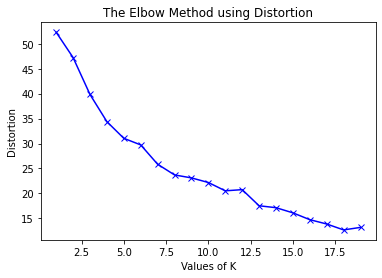

In [36]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [37]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[0 7 2 ... 0 7 7]


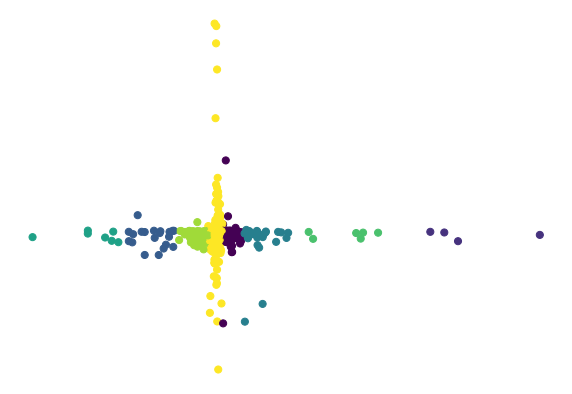

In [38]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [39]:
pd.Series(kmeans.labels_).value_counts() 

#tried the clusters from 7 to 11 and chose 8 because it has more and bigger variety of companies in the clusters

7    1088
0     158
6      60
3      30
2      20
4       7
5       6
1       4
dtype: int64

In [40]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters #adding a label to a df
df['label'] = df['label'].astype(str)

In [41]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    
#shows the highest 

In [42]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster and I'm distinguishing outliers, dropping some of the stocks 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,
0,0.327349,-49.395351,1.309120,5.300146,1.704368,-0.034025
1,0.221496,-1644.023026,0.562477,5.940000,1.255016,-0.079750
2,0.352457,450.224064,0.460211,10.959150,1.855371,0.015050
3,0.262885,-253.329800,0.913730,14.770100,3.037815,-0.030867
4,0.234888,846.430599,0.303203,10.003286,2.283584,-0.037143
5,0.192617,-835.746015,0.881952,5.988500,2.721528,-0.059667
6,0.312703,150.385770,0.695397,8.173250,2.111688,0.012517
7,0.346103,22.781756,2.200923,3.738358,1.532843,0.077911


In [43]:
df_original[df['label'] == '1'] 

#imputing every cluster = outlier and checking what companies it has, if I should keep them or investigate separately 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
11143,PRO,6.617500e+07,15.281,1.402680e+08,5.133070e+08,-0.261,12852000.0,42614000.0,1.553,-14824000.0,...,-69081000.0,-0.038,15.281,-0.139211,-0.224012,0.305443,1.572729,-1576.842105,1.892334,0.273263
17724,MDU,1.378213e+09,2.091,2.358513e+09,7.683059e+09,0.069,339177000.0,200400000.0,6.877,130220000.0,...,335453000.0,-0.020,2.091,0.044307,0.094485,1.692636,6.877864,-1485.500000,1.042285,0.306976
33576,CDAY,2.218000e+08,5.189,7.160000e+08,6.085700e+09,-0.007,26000000.0,144088431.0,1.539,19700000.0,...,78700000.0,-0.032,5.189,0.012340,0.088819,0.180704,1.541547,-2121.250000,1.057567,0.117653
35984,BB,2.670000e+08,1.199,7.360000e+08,3.913000e+09,-0.120,39000000.0,548336000.0,0.487,-49000000.0,...,-60000000.0,-0.004,1.199,-0.015173,-0.183521,0.071124,0.486928,-1392.500000,1.027878,0.188091


In [44]:
df_original[df['label'] == '2'] 


,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5.431000e+06,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
1666,WEC,1.947500e+09,2.877,1.273500e+10,3.495180e+10,0.125,5.048000e+08,315400000.0,6.175,363100000.0,...,1.134000e+09,0.269,2.877,0.033109,0.186444,1.600327,6.174002,342.862454,0.381437,0.364359
4048,TTD,2.159440e+08,19.142,1.894500e+08,1.728761e+09,0.236,-2.806800e+07,45043000.0,4.794,52650000.0,...,1.083180e+08,0.440,19.142,0.079272,0.243813,-0.621877,4.784470,590.409091,1.527736,0.109587
9062,RYN,1.787920e+08,2.942,1.055129e+09,2.860996e+09,0.089,5.006000e+07,129313473.0,1.383,26127000.0,...,5.910500e+07,0.062,2.942,0.020787,0.146131,0.387121,1.382625,528.387097,0.642222,0.368798
13723,OKTA,1.673270e+08,38.289,1.092216e+09,1.955395e+09,-0.302,2.483500e+07,122090000.0,1.371,-44703000.0,...,-2.089130e+08,0.309,38.289,-0.142809,-0.267160,0.204902,1.380537,414.401295,2.803003,0.558565
14411,NVCR,9.923400e+07,38.294,1.635640e+08,4.794480e+08,0.043,6.962000e+06,99297073.0,0.999,153000.0,...,-7.230000e+06,0.166,38.294,-0.017014,0.001542,0.070346,1.002682,507.650602,4.822630,0.341151
15508,NEWR,1.530280e+08,10.342,4.902930e+08,1.158193e+09,-0.178,-1.383800e+07,58733000.0,2.605,-24216000.0,...,-7.781700e+07,0.190,10.342,-0.068381,-0.158246,-0.235390,2.603071,345.842105,2.849362,0.423326
18107,MAXR,1.930000e+08,1.230,3.158000e+09,5.157000e+09,0.249,1.750000e+08,59744715.0,3.230,79000000.0,...,1.090000e+08,0.050,1.230,0.021415,0.409326,2.929129,3.230411,313.400000,0.459839,0.612372
19758,KTOS,1.851000e+08,3.289,3.426000e+08,1.186000e+09,0.016,-1.000000e+06,106600000.0,1.736,9300000.0,...,1.250000e+07,0.035,3.289,0.010623,0.050243,-0.009410,1.741796,507.714286,2.391899,0.288870
21354,IRWD,1.263010e+08,-22.383,4.554820e+08,4.027480e+08,0.379,2.758000e+07,156836000.0,0.805,49593000.0,...,2.150500e+07,0.024,-22.383,0.060734,0.392657,0.175873,0.805398,554.583333,8.016712,1.130935


In [45]:
df_original[df['label'] == '3']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
2759,VCYT,2.973000e+07,5.695,1.360700e+07,2.752120e+08,-0.251,1.790000e+06,49128202.0,0.605,-8197000.0,...,-1.259900e+07,-0.129,5.695,-0.055293,-0.275715,0.036650,0.608719,-216.434109,10.260977,0.049442
3812,TXG,7.528900e+07,17.456,2.971900e+07,6.059230e+08,-0.095,6.700000e+06,39091366.0,1.926,-8080000.0,...,-3.125100e+07,-0.208,17.456,-0.085592,-0.107320,0.069668,0.782874,-366.586538,8.086790,0.049047
3915,TWLO,3.312240e+08,3.150,6.402160e+08,5.150516e+09,-0.272,1.202400e+07,137812597.0,2.403,-93799000.0,...,-3.070630e+08,-0.409,3.150,-0.063020,-0.283189,0.087669,2.415001,-240.293398,8.117542,0.124301
5648,TCMD,5.706300e+07,11.409,1.658800e+07,1.517520e+08,0.075,8.900000e+04,19064162.0,2.993,6049000.0,...,1.097100e+07,-0.155,11.409,0.082663,0.106006,0.004677,2.998825,-435.548387,4.247200,0.109310
7510,SMAR,7.851900e+07,11.079,6.506200e+07,7.977140e+08,-0.359,-4.200000e+04,117761000.0,0.667,-30096000.0,...,-9.594000e+07,-0.201,11.079,-0.142505,-0.383296,-0.000358,0.668372,-241.194030,2.676145,0.081561
8899,SAIA,4.430650e+08,2.963,2.416890e+08,1.415693e+09,0.048,6.557800e+07,26000000.0,17.041,27430000.0,...,1.137190e+08,-0.314,2.963,0.083664,0.061910,2.528453,17.083004,-296.560510,0.813970,0.170721
9485,ROKU,4.112300e+08,22.530,4.013020e+08,1.470234e+09,-0.038,-1.058000e+07,118680000.0,3.465,-17384000.0,...,-5.993700e+07,-0.551,22.530,-0.062819,-0.042273,-0.090031,3.499371,-243.012704,2.372324,0.272951
10533,QTWO,8.684000e+07,10.291,4.700030e+08,1.009434e+09,-0.180,1.895000e+06,48235000.0,1.800,-21858000.0,...,-7.087700e+07,-0.292,10.291,-0.082672,-0.251704,0.039351,1.803316,-277.671233,1.311538,0.465610
10775,PXD,2.643000e+09,2.069,2.595000e+09,1.906700e+10,0.130,8.280000e+08,164000000.0,16.116,481000000.0,...,7.560000e+08,-0.629,2.069,0.041084,0.181990,4.998596,15.955662,-240.651828,0.772035,0.136099
11618,PODD,2.093940e+08,139.445,8.879000e+08,1.142900e+09,0.024,4.693300e+07,62416895.0,3.355,18128000.0,...,1.160000e+07,-1.078,139.445,0.010687,0.086574,0.759169,3.387070,-158.812616,2.824350,0.776883


In [46]:
df_original[df['label'] == '4']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
3943,TU,3.858000e+09,2.880,1.857400e+10,3.797500e+10,0.098,829000000.0,1.210000e+09,2.434,690000000.0,...,1.776000e+09,0.027,2.880,0.048935,0.178849,0.692363,3.222121,717.222222,0.447973,0.489111
9627,RNG,2.528650e+08,18.984,4.154050e+08,1.450747e+09,-0.100,-6162000.0,8.547600e+07,2.958,-20369000.0,...,-5.360700e+07,0.247,18.984,-0.047777,-0.080553,-0.073417,3.012761,682.874494,1.687118,0.286339
12458,PEN,1.452630e+08,11.804,8.229700e+07,6.659010e+08,0.067,4767000.0,3.495729e+07,4.155,10579000.0,...,4.845800e+07,0.131,11.804,0.079636,0.072827,0.136534,4.160560,1253.969466,3.243234,0.123587
15600,NEO,1.068680e+08,6.019,1.328750e+08,7.095060e+08,0.059,3359000.0,1.044330e+08,1.023,2321000.0,...,8.006000e+06,0.033,6.019,0.012081,0.021718,0.032172,1.023565,886.363636,4.182180,0.187278
22128,IIVI,6.663310e+08,1.481,2.420049e+09,5.208209e+09,-0.147,81875000.0,9.084920e+07,7.334,-79065000.0,...,-7.154500e+07,0.038,1.481,-0.019771,-0.118657,0.901219,7.334473,886.052632,1.514597,0.464660
31121,CSII,6.833400e+07,11.935,2.090300e+07,2.241920e+08,-0.050,3940000.0,3.406941e+07,2.006,-3374000.0,...,-7.040000e+06,0.063,11.935,-0.032328,-0.049375,0.111931,1.941295,771.269841,2.725727,0.093237
31226,CRWD,1.521090e+08,16.920,0.000000e+00,1.404906e+09,-0.187,66107000.0,1.480620e+08,1.027,-31132000.0,...,-1.417790e+08,0.084,16.920,-0.132198,-0.204669,0.321618,0.740028,727.261905,2.184262,0.000000


In [47]:
df_original[df['label'] == '5']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
10452,RAMP,1.022170e+08,2.848,0.000000e+00,1.343852e+09,-0.372,1.580400e+07,67695513.0,1.510,-4.148500e+07,...,-1.658430e+08,-0.046,2.848,-0.118052,-0.405852,0.233457,1.509952,-1045.000000,5.834137,0.000000
18736,LPX,5.370000e+08,3.516,3.840000e+08,1.835000e+09,-0.095,1.010000e+08,116700000.0,4.602,-7.300000e+07,...,-5.000000e+06,-0.033,3.516,-0.002481,-0.135940,0.859915,4.572025,-899.090909,1.471311,0.209264
22325,ICUI,3.155230e+08,2.809,0.000000e+00,1.692382e+09,0.065,4.886400e+07,20695000.0,15.246,1.782300e+07,...,1.010350e+08,-0.198,2.809,0.061547,0.056487,2.363625,15.262319,-945.050505,1.991629,0.000000
27503,EVBG,5.711100e+07,11.976,4.302820e+08,8.372960e+08,-0.230,1.463000e+06,33821146.0,1.689,-1.021500e+07,...,-5.225000e+07,-0.084,11.976,-0.096393,-0.178862,0.043296,1.690152,-929.523810,3.591654,0.513895
30317,D,4.475000e+09,2.131,3.789700e+10,1.038230e+11,0.225,1.495000e+09,823093381.0,5.437,1.221000e+09,...,1.358000e+09,-0.142,2.131,0.013345,0.272849,1.816319,5.436807,-583.239437,0.282825,0.365015
37968,AMRN,1.432770e+08,12.651,5.957300e+07,8.822090e+08,0.049,-8.936000e+06,359338000.0,0.399,5.490000e+06,...,-2.264500e+07,-0.035,12.651,-0.036069,0.038317,-0.024898,0.399204,-612.571429,3.157611,0.067527


In [48]:
df_original[df['label'] == '6']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,3.655400e+07,2.766790e+08,0.680,1.055300e+07,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,3.221100e+07,1.125170e+08,2.043,-3.230100e+07,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
623,XEC,6.572440e+08,1.494,2.253120e+09,7.140029e+09,-0.458,3.598090e+08,1.018101e+08,6.456,-3.353320e+08,...,-1.246190e+08,0.485,1.494,-0.016665,-0.510209,3.534118,6.455585,108.226804,0.756623,0.315562
749,WWE,3.228020e+08,18.509,5.789450e+08,9.922330e+08,0.215,1.194170e+08,7.807600e+07,4.134,9.982000e+07,...,7.706100e+07,0.673,18.509,0.089076,0.309230,1.520150,4.109191,96.389302,1.089759,0.583477
1018,WSC,2.701920e+08,3.351,1.780151e+09,2.897649e+09,0.036,7.349000e+07,1.087951e+08,2.483,3.843600e+07,...,-1.112200e+07,0.184,3.351,-0.003938,0.142254,0.629326,2.313768,100.489130,0.782246,0.614343
1447,WING,5.318600e+07,-12.124,3.108690e+08,1.661130e+08,0.057,9.997000e+06,2.945700e+07,1.806,8.894000e+06,...,2.047600e+07,0.547,-12.124,0.128850,0.167224,0.339418,1.805769,157.605119,0.692824,1.871431
1504,WH,4.920000e+08,4.932,2.122000e+09,4.533000e+09,0.130,9.100000e+07,9.516746e+07,5.170,1.020000e+08,...,1.570000e+08,0.525,4.932,0.033542,0.207317,0.956209,5.169834,119.638095,0.861472,0.468123
2577,VICR,6.312500e+07,9.183,2.855000e+06,2.407270e+08,0.021,5.669000e+06,4.048300e+07,1.559,8.950000e+05,...,1.409800e+07,0.242,9.183,0.060361,0.014178,0.140308,1.562343,193.057851,4.102339,0.011860
4214,TRUP,1.054830e+08,9.572,2.608600e+07,2.572000e+08,0.006,4.532000e+06,3.480134e+07,3.031,6.540000e+05,...,-1.809000e+06,0.311,9.572,-0.007601,0.006200,0.129681,3.018335,120.450161,1.688491,0.101423
4763,TNDM,1.083980e+08,18.066,2.038300e+07,3.261100e+08,0.024,1.944200e+07,5.922400e+07,1.830,2.143000e+06,...,-2.475300e+07,0.382,18.066,-0.090959,0.019770,0.329008,1.834367,156.047120,2.243984,0.062503


In [67]:
df_original[df['label'] == '7']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,5.820000e+08,4.764120e+08,3.514,4.930000e+08,...,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,7
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,9.404900e+07,9.477330e+08,0.427,4.332000e+06,...,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,7
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,2.650000e+08,5.392148e+07,22.106,1.880000e+08,...,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,7
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,4.233000e+08,2.060000e+08,10.319,3.368000e+08,...,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678,7
221,ZAYO,6.537000e+08,5.561,6.436700e+09,9.961200e+09,0.094,2.564000e+08,2.368000e+08,2.761,1.411000e+08,...,0.731,5.561,0.018418,0.215848,1.082634,2.760211,47.400821,0.386795,0.646177,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40133,AAPL,9.181900e+10,14.382,1.082920e+11,3.406180e+11,0.242,3.051600e+10,4.415040e+09,20.797,2.556900e+10,...,14.489,14.382,0.171291,0.278472,6.867923,20.664759,20.001380,1.439962,0.317928,7
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,1.583630e+08,6.942300e+07,30.431,1.261390e+08,...,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,7
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,2.734200e+07,5.206083e+07,2.354,2.143000e+07,...,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,7
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,2.620000e+08,1.855729e+08,13.127,-1.080000e+08,...,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,7


----------------------------------------------------------------------------------------------------


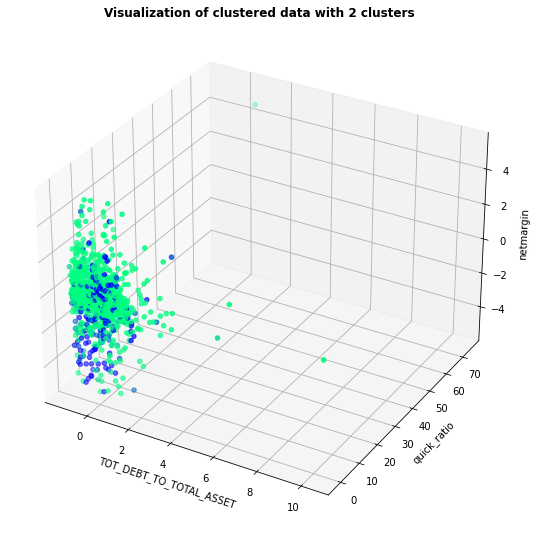

----------------------------------------------------------------------------------------------------


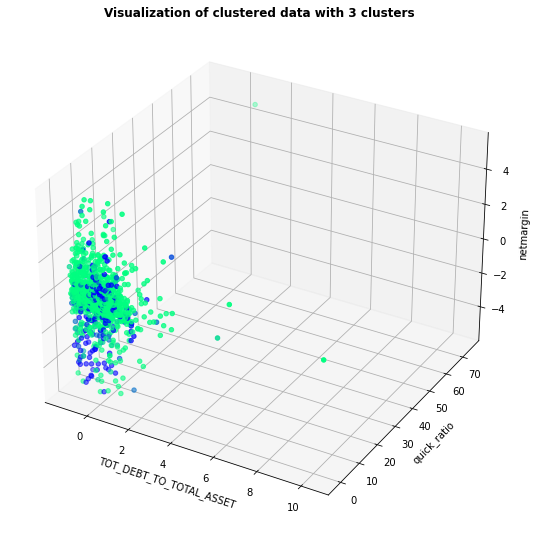

In [50]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 4]
    C3 = cluster_centers[:, 5]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,4]
    z = X_train_robust[:,5]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[4])
    ax.set_zlabel(column_names[5])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

----------------------------------------------------------------------------------------------------


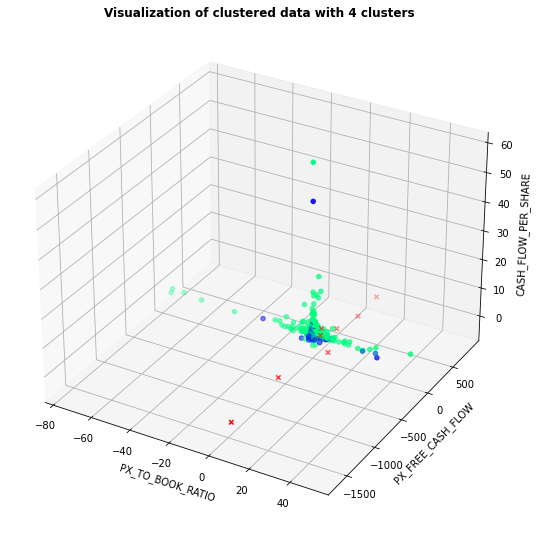

----------------------------------------------------------------------------------------------------


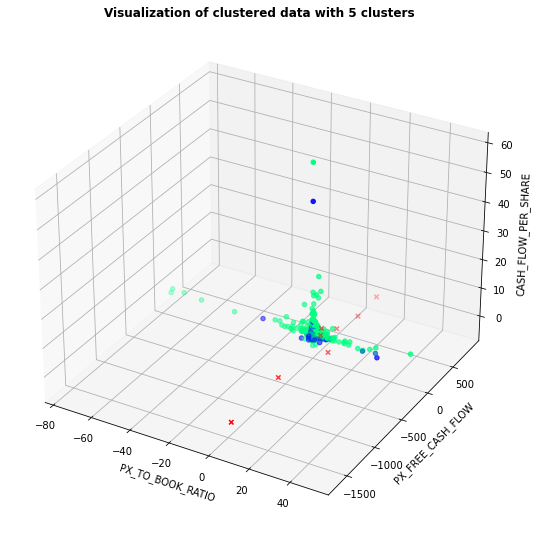

In [51]:
clusters = [4,5]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 3]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,3]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[3])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [52]:
from sklearn import datasets, metrics

In [53]:
print(metrics.silhouette_score(X, y_pred, metric='euclidean')) 

#closer to 1, clustering is better. Test with cluster numbers:6, 7

0.619544578032226


In [54]:
#let's see the other method of clustering: GaussianMixture, all the steps that i did above can be applied here too.
#spherical and diagonal covariances didn't perform better than the full one, the silhouette score was worse in both of them

gauss = GaussianMixture(n_components=4, random_state=10)
gauss.fit_predict(X)
y_pred = gauss.predict(X)
print(y_pred)

[2 3 1 ... 0 3 3]


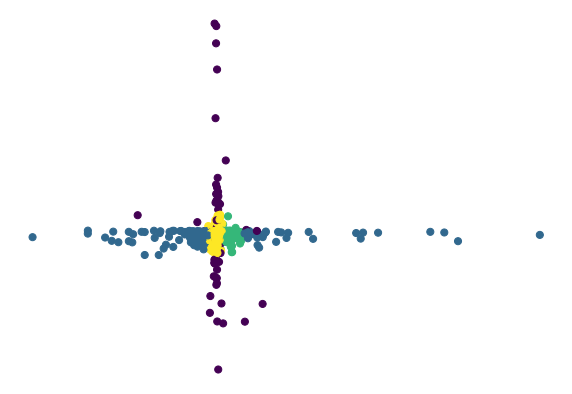

In [55]:
pca = PCA(n_components=3).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [56]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1373, 4)

In [57]:
print(metrics.silhouette_score(X, y_pred, metric='euclidean')) 


#2 clusters is better for silhouette score.

0.5231161145540553


In [58]:
df_original['label'] = kmeans.labels_ #adding a new column 'label' to the original df

In [59]:
from ipywidgets import interact

In [61]:
px.scatter(data_frame=df_original, x='RETURN_ON_ASSET', y='quick_ratio', color = 'label', hover_data=['ticker', 'netmargin', 'PX_FREE_CASH_FLOW'])

In [63]:
@interact
def plotting(x=df_original.columns, y = df_original.columns):
    fig = px.scatter(data_frame=df_original, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

interactive(children=(Dropdown(description='x', options=('ticker', 'revenue', 'pb', 'debt', 'assets', 'netmarg…

<Figure size 648x504 with 0 Axes>

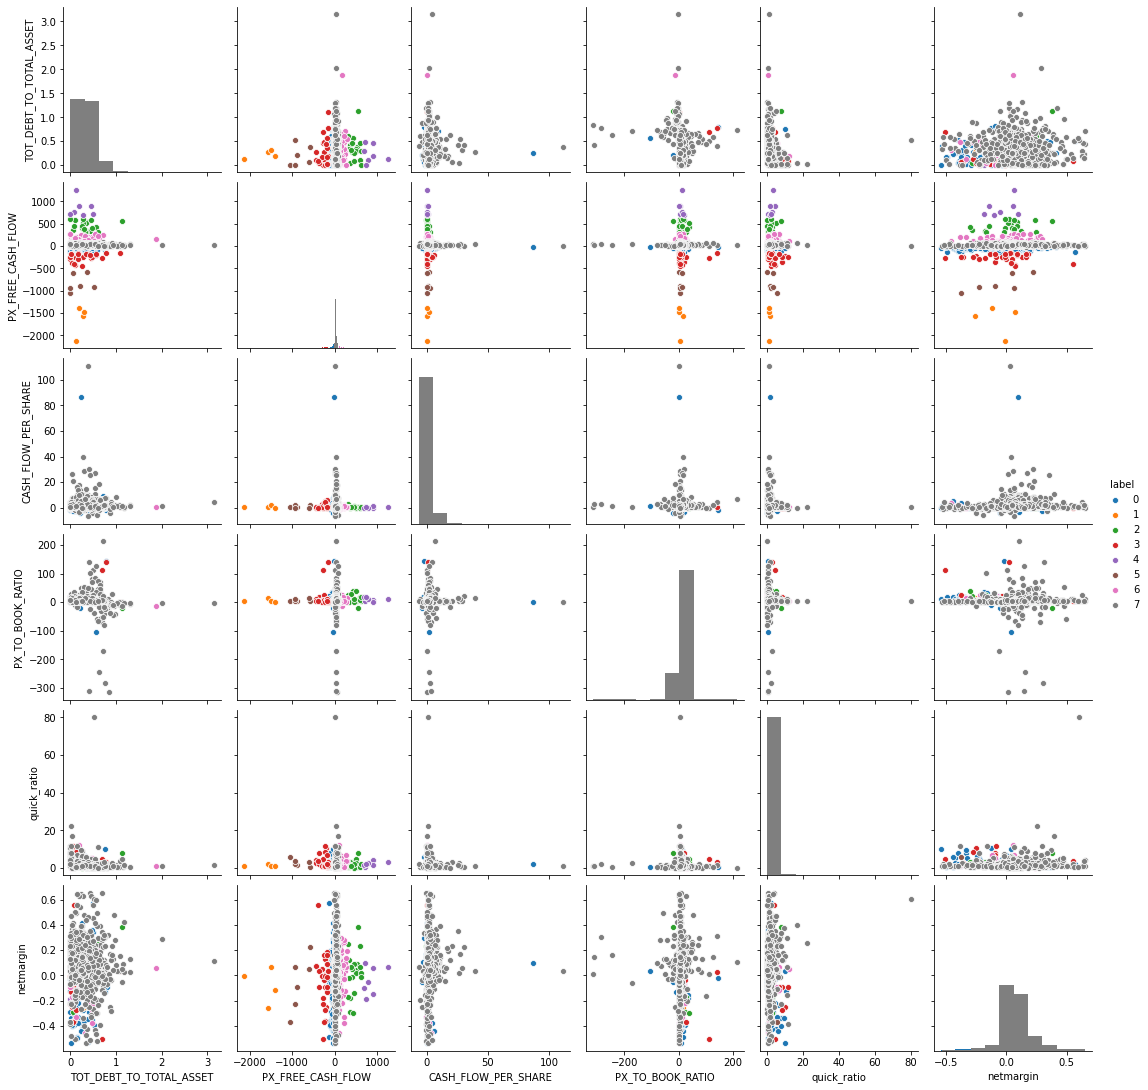

<Figure size 648x504 with 0 Axes>

In [64]:
sns.pairplot(df, hue="label", diag_kind="hist")
plt.figure(figsize=(9,7))
#very interesting.. We can actually see the clusters very distintcly at some plots.
#amazing tool for futher investigation. 
#on price per cash flow column can see distinguished clusters.

In [77]:
df_original[df['label'] == '7']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,5.820000e+08,4.764120e+08,3.514,4.930000e+08,...,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,7
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,9.404900e+07,9.477330e+08,0.427,4.332000e+06,...,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,7
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,2.650000e+08,5.392148e+07,22.106,1.880000e+08,...,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,7
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,4.233000e+08,2.060000e+08,10.319,3.368000e+08,...,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678,7
221,ZAYO,6.537000e+08,5.561,6.436700e+09,9.961200e+09,0.094,2.564000e+08,2.368000e+08,2.761,1.411000e+08,...,0.731,5.561,0.018418,0.215848,1.082634,2.760211,47.400821,0.386795,0.646177,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40133,AAPL,9.181900e+10,14.382,1.082920e+11,3.406180e+11,0.242,3.051600e+10,4.415040e+09,20.797,2.556900e+10,...,14.489,14.382,0.171291,0.278472,6.867923,20.664759,20.001380,1.439962,0.317928,7
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,1.583630e+08,6.942300e+07,30.431,1.261390e+08,...,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,7
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,2.734200e+07,5.206083e+07,2.354,2.143000e+07,...,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,7
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,2.620000e+08,1.855729e+08,13.127,-1.080000e+08,...,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,7


In Cluster 0 companies have a PX_FREE_CASH_FLOW - price to free cash flow, the lower the number, the better. Currently, the average Price to Cash Flow (P/CF) for the stocks in the S&P 500 is 14.05. A value of less than 15 to 20 is generally considered good. Here though it might be an indication that stocks are undervalued by a lot but also that they could go bankrupt.
Stocks like American Airlines are not in the best shape,they were bankrupted before. Even in this cluster AAL is an outlier 
They might bankrupt again in these unstable covid days.It might recover or go bankrupt, could be a good investment too.     
It has a history of recovering from bankruptcy. This cluster of stocks is not profitable right away, some of them can survive and perform well over time. 
Definitely worth the time to investigate futher more for potential investments. 

Cluster 1 has only 4 companies which have extremely low price to free cash flow just like the cluster 0, but the situation is 10X worse. Futher investigations needed. These companies might be really undervalued.

Cluster 2, 20 companies. PX_FREE_CASH_FLOW as opposite to 2 clusters above is very high. A high P/CF ratio indicated that the specific firm is trading at a high price but is not generating enough cash flows to support multiple sectors in the business. 
Personally I'm not interested in this cluster.

Cluster 3, with 30 companies. The cluster has a decent PX_TO_BOOK_RATIO. The price-to-book ratio (P/B ratio) is an indicator used to rate a publicly-traded company. Companies use the price-to-book ratio (P/B ratio) to compare a firm's market capitalization to its book value. It's calculated by dividing the company's stock price per share by its book value per share (BVPS). P/B is equal to share price divided by book value per share. ... A lower / negative P/B ratio can mean that the stock is undervalued or something is fundamentally wrong with the company. This ratio gives you an idea if you're paying too much for what would be left if the company declared bankruptcy. PODD AND MDB are good outliers in the group, they have good fundamentals and business is functioning well. However the whole group has a negative PX_FREE_CASH_FLOW which indicate in this case that they're undervalued and cood be a good investing point. I'll look into it more, worth the time to research. 

Cluster 4, PX_TO_BOOK_RATIO is very high, could be overvalued. The price-to-book (P/B) ratio has been favored by value investors for decades and is widely used by market analysts. Traditionally, any value under 1.0 is considered a good P/B value, indicating a potentially undervalued stock. However, value investors often consider stocks with a P/B value under 3.0 
Might consider IIVI and TU to invest in. Very high PX_FREE_CASH_FLOW, meaning that companies are trading at a higher price but are not generating enough cash or equal to what they're trading at. 

Cluster 5, with 6 companies. This cluster is very interesing, has a good quick_ratio = The quick ratio is an indicator of a company's short-term liquidity position and measures a company's ability to meet its short-term obligations with its most liquid assets. PX_FREE_CASH_FLOW is very negative, I'd look more into RAMP. REVENUE_PER_SHARE - Increasing revenue per share (RPS) over time is a good sign, because it means each share now has claim to more revenues. ICUI has a very good RPS. 

Cluster 6, 60 companies.  PX_TO_BOOK_RATIO is evaluated high on the market. REVENUE_PER_SHARE = these companies are generating more money over time. PX_FREE_CASH_FLOW is high, they're traded at a higher price than generating the cash flow. Quick_ratio is good, most of them can liquid their positions quick if needed. These are considered as good growth stocks for value investors. 
Zoom is in this cluster. 

Cluster 7. This cluster has a majority of companies in it. They're growth and highly priced stocks with a high PX_FREE_CASH_FLOW. PX_TO_BOOK_RATIO - highly valued in the business market as stable with good fundamentals companies. REVENUE_PER_SHARE is very good, these stocks are generating good cash flow over time. 
APPLE company is in this cluster. 